In [42]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [114]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:]) 

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [152]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.02 #*(5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# bngain = torch.ones(1, n_hidden)
# bnbias = torch.zeros(1, n_hidden)
# bnmean_running = torch.ones(1, n_hidden)
# bnstd_running = torch.zeros(1, n_hidden)

parameters = [C, W1, W2, b2]#, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [151]:
embd = C[Xtr]
embd = embd.view(embd.shape[0], -1)
h_pre_act = embd @ W1 + b1
h = torch.tanh(h_pre_act)
h.retain_grad()
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss.backward()
loss.item()

3.296825647354126

[Unsolved]: The gradient graph for h looks the same even after scaling W1 and b1

In [153]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  
  # bnmeani = hpreact.mean(0, keepdims=True)
  # bnstdi = hpreact.std(0, keepdims=True)
  # hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
  
  # with torch.no_grad():
  #   bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  #   bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  h = torch.tanh(hpreact) # hidden layer
  h.retain_grad()
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  # if i > 1000:
  #   break
  


      0/ 200000: 3.2974
  10000/ 200000: 2.5450
  20000/ 200000: 2.3364
  30000/ 200000: 2.0663
  40000/ 200000: 2.0811
  50000/ 200000: 2.4698
  60000/ 200000: 2.2125
  70000/ 200000: 2.0439
  80000/ 200000: 2.0107
  90000/ 200000: 2.1468
 100000/ 200000: 2.3570
 110000/ 200000: 2.1154
 120000/ 200000: 2.2511
 130000/ 200000: 2.3574
 140000/ 200000: 2.2539
 150000/ 200000: 2.3030
 160000/ 200000: 2.1626
 170000/ 200000: 2.0514
 180000/ 200000: 2.3458
 190000/ 200000: 1.8931


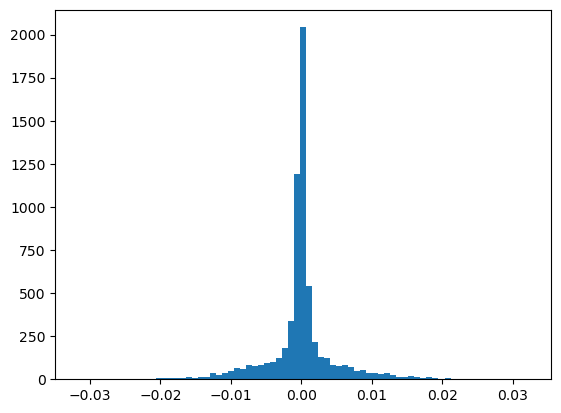

In [156]:
plt.hist(h.grad.view(-1).tolist(), bins=75);

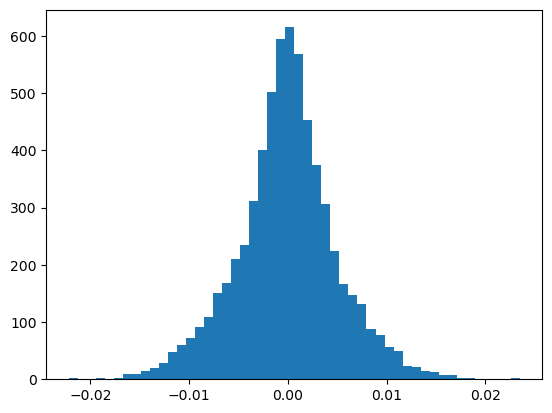

In [149]:
plt.hist(h.grad.view(-1).tolist(), bins=50);

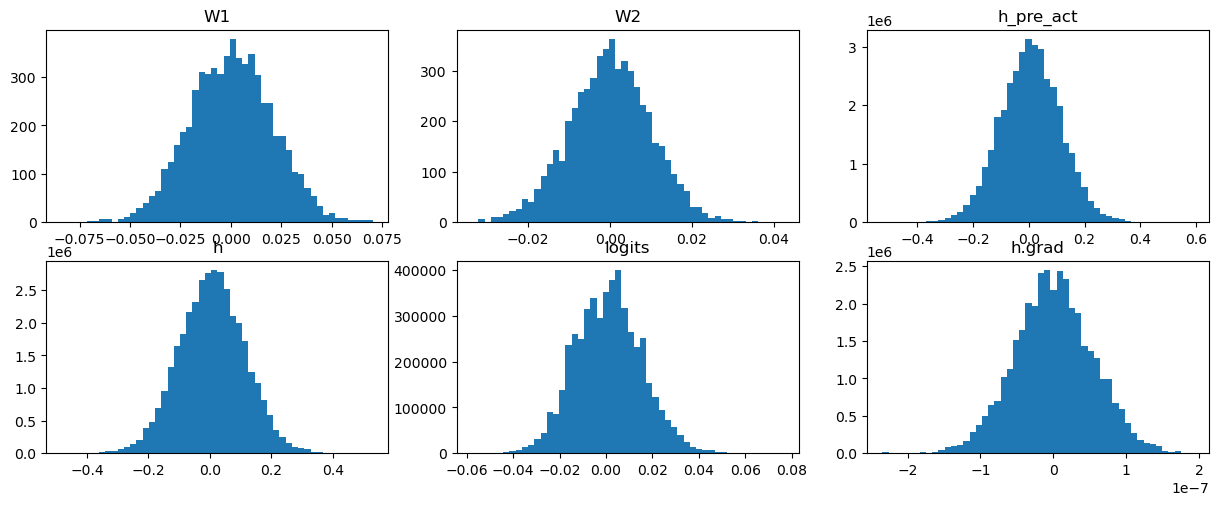

In [132]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5.5))
axs = axs.flatten()

variables = [W1, W2, h_pre_act, h, logits, h.grad]
title = ['W1', 'W2', 'h_pre_act', 'h', 'logits', 'h.grad']

for i, var in enumerate(variables):
  axs[i].hist(var.view(-1).detach().numpy(), bins = 50)
  axs[i].set_title(f'{title[i]}')

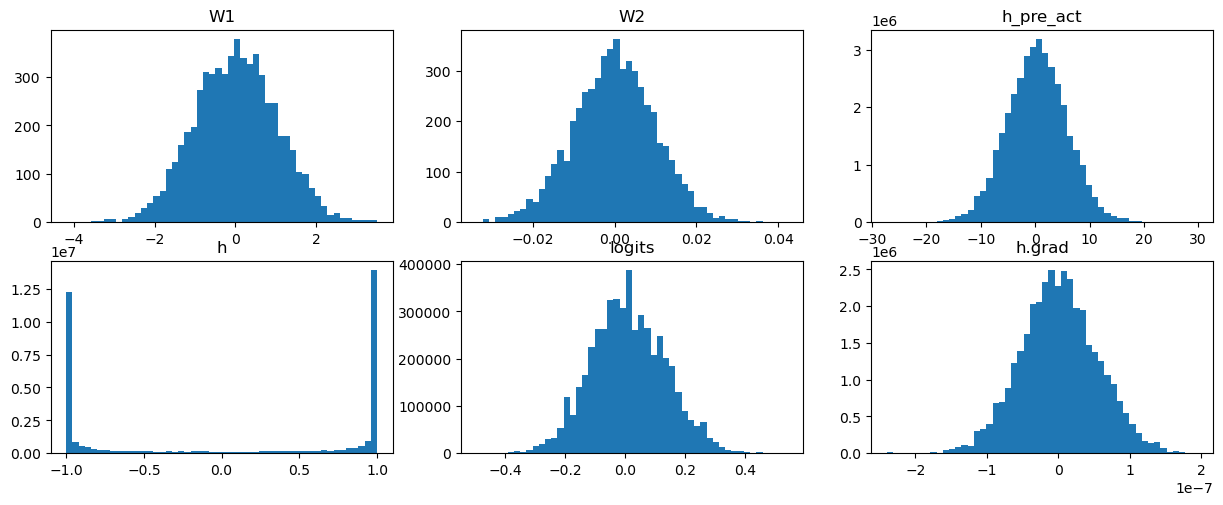

In [112]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5.5))
axs = axs.flatten()

variables = [W1, W2, h_pre_act, h, logits, h.grad]
title = ['W1', 'W2', 'h_pre_act', 'h', 'logits', 'h.grad']

for i, var in enumerate(variables):
  axs[i].hist(var.view(-1).detach().numpy(), bins = 50)
  axs[i].set_title(f'{title[i]}')